In [111]:
# Load libraries
import numpy as np 
import pandas as pd 
import sys
import os


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode()

from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

from pandas import set_option
from tabulate import tabulate

In [112]:
class CFG:
    SEED = 2023
    imgdim1 = 20
    imgdim2 = 10

plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (CFG.imgdim1, CFG.imgdim2)})

In [113]:
pd.set_option('display.max_columns', None)

In [114]:
data = pd.read_csv("diabetes.csv")

In [115]:
data.head()

id  encounter_id  patient_nbr             race  gender      age weight  \
0   1       2278392      8222157        Caucasian  Female   [0-10)      ?   
1   2        149190     55629189        Caucasian  Female  [10-20)      ?   
2   3         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3   4        500364     82442376        Caucasian    Male  [30-40)      ?   
4   5         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinology                  41   
1                 3          ?                         ?                  59   
2                 2          ?                         ?                  11   
3                 2          ?                         ?                  44   
4                 1          ?                         ?                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83       ?      ?                 1          None   
1                 0     276  250.01    255                 9          None   
2                 1     648     250    V27                 6          None   
3                 0       8  250.43    403                 7          None   
4                 0     197     157    250                 5          None   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      None        No          No          No             No          No   
1      None        No          No          No             No          No   
2      None        No          No          No             No          No   
3      None        No          No          No             No          No   
4      None        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide.metformin glipizide.metformin glimepiride.pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No              

The below Features are removed as they represent unique row and do not contribute to model building

In [116]:
##Redundant Features
cols = ['id', 'encounter_id', 'patient_nbr','payer_code']
data[cols]

id  encounter_id  patient_nbr payer_code
0            1       2278392      8222157          ?
1            2        149190     55629189          ?
2            3         64410     86047875          ?
3            4        500364     82442376          ?
4            5         16680     42519267          ?
...        ...           ...          ...        ...
101761  101762     443847548    100162476         MC
101762  101763     443847782     74694222         MC
101763  101764     443854148     41088789         MC
101764  101765     443857166     31693671         MC
101765  101766     443867222    175429310          ?

[101766 rows x 4 columns]

In [117]:
data = data.drop(columns = cols)

Let’s have a look at data dimensionality, feature names, and feature types.



In [118]:
data.shape

(101766, 47)

In [119]:
data.columns

Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    101766 non-null  object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   medical_specialty         101766 non-null  object
 9   num_lab_procedures        101766 non-null  int64 
 10  num_procedures            101766 non-null  int64 
 11  num_medications           101766 non-null  int64 
 12  number_outpatient         101766 non-null  int64 
 13  number_emergency          101766 non-null  int64 
 14  numb

In [121]:
data.describe()

admission_type_id  discharge_disposition_id  admission_source_id  \
count      101766.000000             101766.000000        101766.000000   
mean            2.024006                  3.715642             5.754437   
std             1.445403                  5.280166             4.064081   
min             1.000000                  1.000000             1.000000   
25%             1.000000                  1.000000             1.000000   
50%             1.000000                  1.000000             7.000000   
75%             3.000000                  4.000000             7.000000   
max             8.000000                 28.000000            25.000000   

       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count     101766.000000       101766.000000   101766.000000    101766.000000   
mean           4.395987           43.095641        1.339730        16.021844   
std            2.985108           19.674362        1.705807         8.127566   
min            1.000000            1.000000        0.000000         1.000000   
25%            2.000000           31.000000        0.000000        10.000000   
50%            4.000000           44.000000        1.000000        15.000000   
75%            6.000000           57.000000        2.000000        20.000000   
max           14.000000          132.000000        6.000000        81.000000   

       number_outpatient  number_emergency  number_inpatient  number_diagnoses  
count      101766.000000     101766.000000     101766.000000     101766.000000  
mean            0.369357          0.197836          0.635566          7.422607  
std             1.267265          0.930472          1.262863          1.933600  
min             0.000000          0.000000          0.000000          1.000000  
25%             0.000000          0.000000          0.000000          6.000000  
50%             0.000000          0.000000          0.000000          8.000000  
75%             0.000000          0.000000          1.000000          9.000000  
max            42.000000         76.000000         21.000000         16.000000

In [122]:
data.describe(include=["object", "bool"])

race  gender      age  weight medical_specialty  diag_1  diag_2  \
count      101766  101766   101766  101766            101766  101766  101766   
unique          6       3       10      10                73     717     749   
top     Caucasian  Female  [70-80)       ?                 ?     428     276   
freq        76099   54708    26068   98569             49949    6862    6752   

        diag_3 max_glu_serum A1Cresult metformin repaglinide nateglinide  \
count   101766        101766    101766    101766      101766      101766   
unique     790             4         4         4           4           4   
top        250          None      None        No          No          No   
freq     11555         96420     84748     81778      100227      101063   

       chlorpropamide glimepiride acetohexamide glipizide glyburide  \
count          101766      101766        101766    101766    101766   
unique              4           4             2         4         4   
top                No          No            No        No        No   
freq           101680       96575        101765     89080     91116   

       tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone  \
count       101766       101766        101766   101766   101766       101766   
unique           2            4             4        4        4            2   
top             No           No            No       No       No           No   
freq        101743        94438         95401   101458   101728       101763   

       tolazamide examide citoglipton insulin glyburide.metformin  \
count      101766  101766      101766  101766              101766   
unique          3       1           1       4                   4   
top            No      No          No      No                  No   
freq       101727  101766      101766   47383              101060   

       glipizide.metformin glimepiride.pioglitazone metformin.rosiglitazone  \
count               101766                   101766                  101766   
unique                   2                        2                       2   
top                     No                       No                      No   
freq                101753                   101765                  101764   

       metformin.pioglitazone  change diabetesMed readmitted  
count                  101766  101766      101766     101766  
unique                      2       2           2          3  
top                        No      No         Yes         NO  
freq                   101765   54755       78363      54864

In [123]:
data["diabetesMed"].value_counts(normalize=True)

Yes    0.770031
No     0.229969
Name: diabetesMed, dtype: float64

In [124]:
data["diabetesMed"].value_counts()

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

In [125]:
data["diabetesMed"] = data["diabetesMed"].map(lambda x: 1 if x == 'Yes' else 0)

In [126]:
data["diabetesMed"].mean()

0.7700312481575379

Missing values in this dataset are represented by ‘?’. Only very few of the columns have missing values.

In [127]:
np.nan

nan

In [128]:
data = data.replace("?", np.nan)

In [129]:
print("Check for the number of Duplicate Data")
data.duplicated().sum()

Check for the number of Duplicate Data


0

In [130]:
missing = data.isna().sum()
print("Features with Missing Values")
100 * missing[missing>0]/data.shape[0]

Features with Missing Values


race                  2.233555
weight               96.858479
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
dtype: float64

Six Features have missing values, a closer look at them to find a proper method to replacing such, either using mean, meadian or removing the features in entirety

Since weight is more than 70% missing we drop it 

In [131]:
diag_1 = data.diag_1.mode()[0]
diag_2 = data.diag_2.mode()[0]
diag_3 = data.diag_3.mode()[0]

In [132]:
data['diag_1'] = data['diag_1'].apply(lambda x : diag_1 if x == np.nan else x)
data['diag_2'] = data['diag_1'].apply(lambda x : diag_2 if x == np.nan else x)
data['diag_3'] = data['diag_3'].apply(lambda x : diag_3 if x == np.nan else x)

In [133]:
data.diag_1 = data.diag_1.fillna(diag_1)
data.diag_2 = data.diag_2.fillna(diag_2)
data.diag_3 = data.diag_3.fillna(diag_3)

In [134]:
data.drop('weight', axis = 'columns', inplace = True)

## Data Transformation

Discharge Disposition ID corresponding to [11 or 13 or 14 or 19 or 20 or 21] indicates patient has expired so there is no chance that it will readmit again so we will remove these records.

Discharge Disposition ID has lots of distinct values using domain knowledge we will convert them into small number of categories.

In [135]:
data['discharge_disposition_id'] = data['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26] 
                                                                           else int(x) )))))

data = data[~data.discharge_disposition_id.isin([11,13,14,19,20,21])]

data['admission_type_id'] = data['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

data['admission_source_id'] = data['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

In [136]:
ageDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

data['age'] = data['age'].apply(lambda x : ageDict[x])

The medical_specialty feature, which is crucial, has too many distinct values, so when we apply one hot encoding, it will unnecessarily create a lot of features, according to our research. We used a frequency-based method and domain knowledge, such as the idea that all types of surgons should be included under the "surgon" category, to divide them up into fewer categories.

We failed to group below medical specialist so we grouped them into 'ungrouped' category.
- Endocrinology -- glands
- Gastroenterology --stomach
- Gynecology -- women reproduction system
- Hematology -- Blood
- Hematology/Oncology -- Blood
- Hospitalist -- one who takes care of admitted patients
- Oncology -- cancer
- Ophthalmology -- eye
- otolaryngology -- ears, nose, and throat
- Pulmonology -- respiratory
- Radiology -- diagnosing and treating injuries and diseases using medical imaging (radiology) procedures (exams/tests) such as X-rays

In [137]:
data['medical_specialty'].value_counts()

InternalMedicine                    14328
Emergency/Trauma                     7449
Family/GeneralPractice               7302
Cardiology                           5296
Surgery-General                      3068
                                    ...  
Perinatology                            1
Neurophysiology                         1
Psychiatry-Addictive                    1
Pediatrics-InfectiousDiseases           1
Surgery-PlasticwithinHeadandNeck        1
Name: medical_specialty, Length: 72, dtype: int64

In [138]:
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 
                 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist']

low_frequency = ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology',\
                'Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent',\
                'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric',\
                'Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices',
                'Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']

pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology',\
               'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']

psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']


neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']


surgery = ['Surgeon', 'Surgery-Cardiovascular', 
          'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', 
             'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic',
             'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
             
ungrouped = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases',\
           'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']


missing = ['MISS_VALUE']

colMedical = []

for val in data['medical_specialty'] :
    if val in pediatrics :
        colMedical.append('pediatrics')
    elif val in psychic :
        colMedical.append('psychic')
    elif val in neurology :
        colMedical.append('neurology')
    elif val in surgery :
        colMedical.append('surgery')
    elif val in high_frequency :
        colMedical.append('high_freq')
    elif val in low_frequency :
        colMedical.append('low_freq')
    elif val in ungrouped :
        colMedical.append('ungrouped')
    elif val in missing :
        colMedical.append('missing')
    else:
        colMedical.append('missing')

data['medical_specialty'] = colMedical
 

## Feature Engineering

Domain Knowledge
Type --> ICD Values --> Description

- Circulatory --> 390–459, 785 --> Diseases of the circulatory system
- Respiratory --> 460–519, 786 --> Diseases of the respiratory system
- Digestive --> 520–579, 787 --> Diseases of the digestive system
- Diabetes --> 250.xx --> Diabetes mellitus
- Injury --> 800–999 --> Injury and poisoning
- Musculoskeletal --> 710–739 --> Diseases of the musculoskeletal system and connective tissue
- Genitourinary --> 580–629, 788 --> Diseases of the genitourinary system
- Neoplasms --> 140–239 --> Neoplasms
- Pregnecy --> 630–679 --> Complications of pregnancy, childbirth, and the puerperium
- Other

In [139]:
data['diag_1'] = data['diag_1'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

data['diag_2'] = data['diag_2'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

data['diag_3'] = data['diag_3'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))  

Redmitted column has values like '>30' that is patient readmitted after 30 days and 'NO' that is patient not readmitted and '<30' that is patient readmitted before 30 days
lets replace '>30'/'NO' with 0 and '<30' with 1

In [140]:
data['readmitted'] = data['readmitted'].apply(lambda x : 0 if (x == '>30' or x == 'NO') else 1)

In [141]:
data.readmitted.value_counts()

0    88757
1    11357
Name: readmitted, dtype: int64

## Data Visualization

<Axes: ylabel='readmitted'>

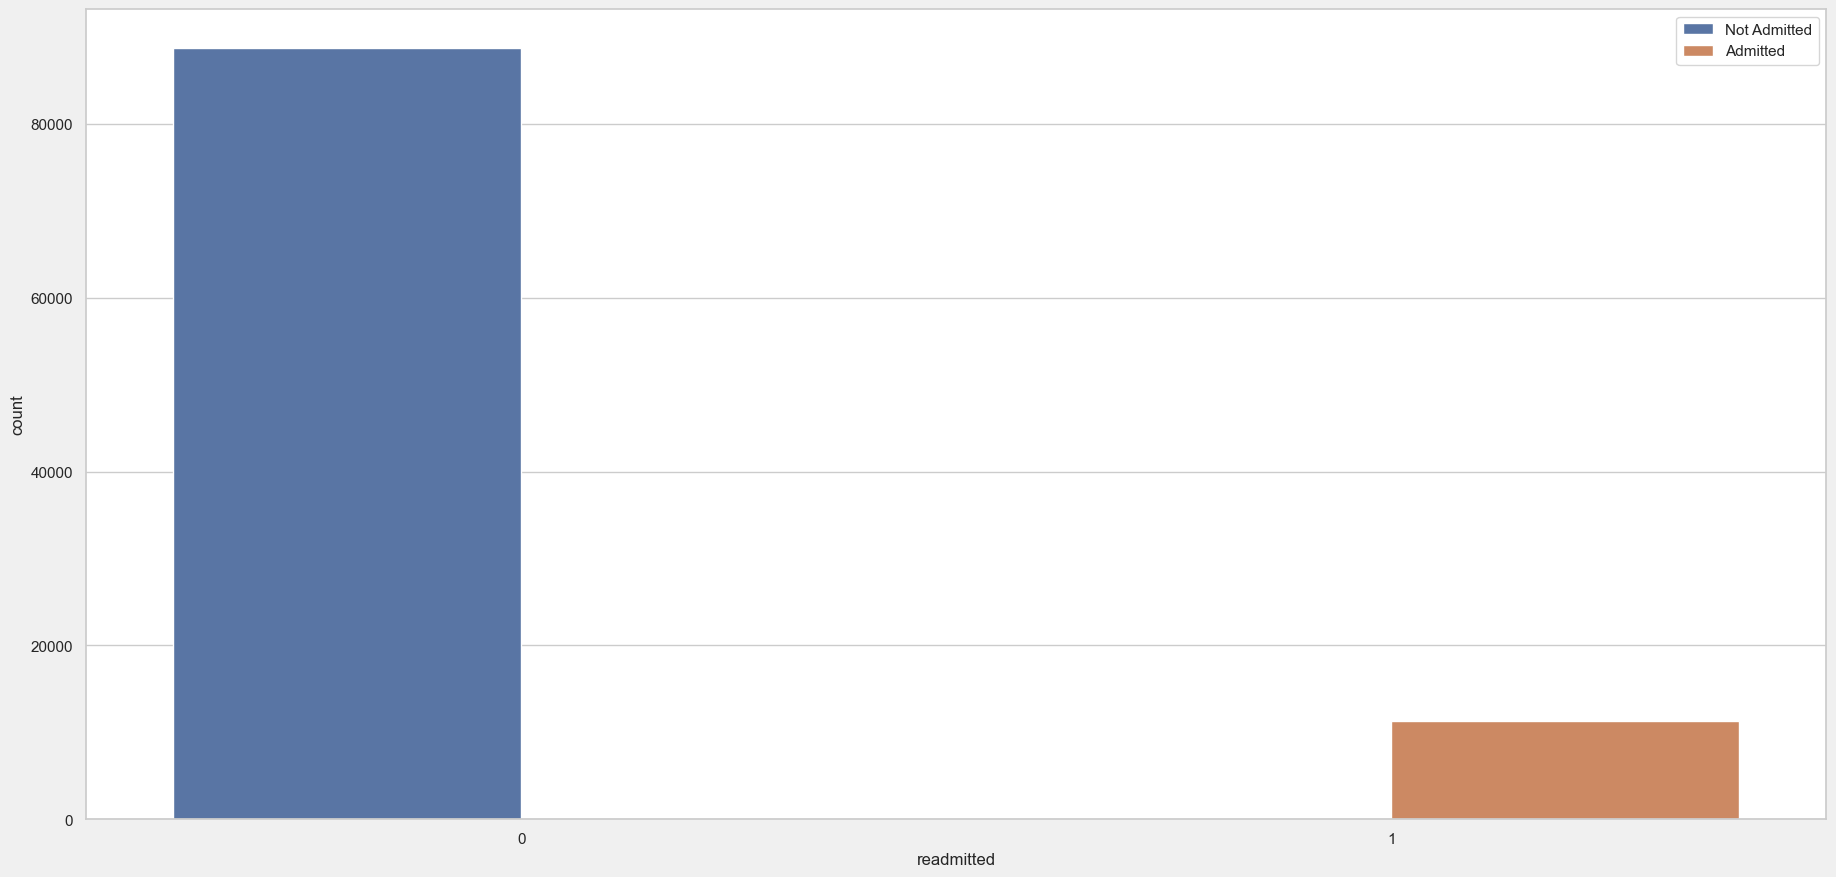

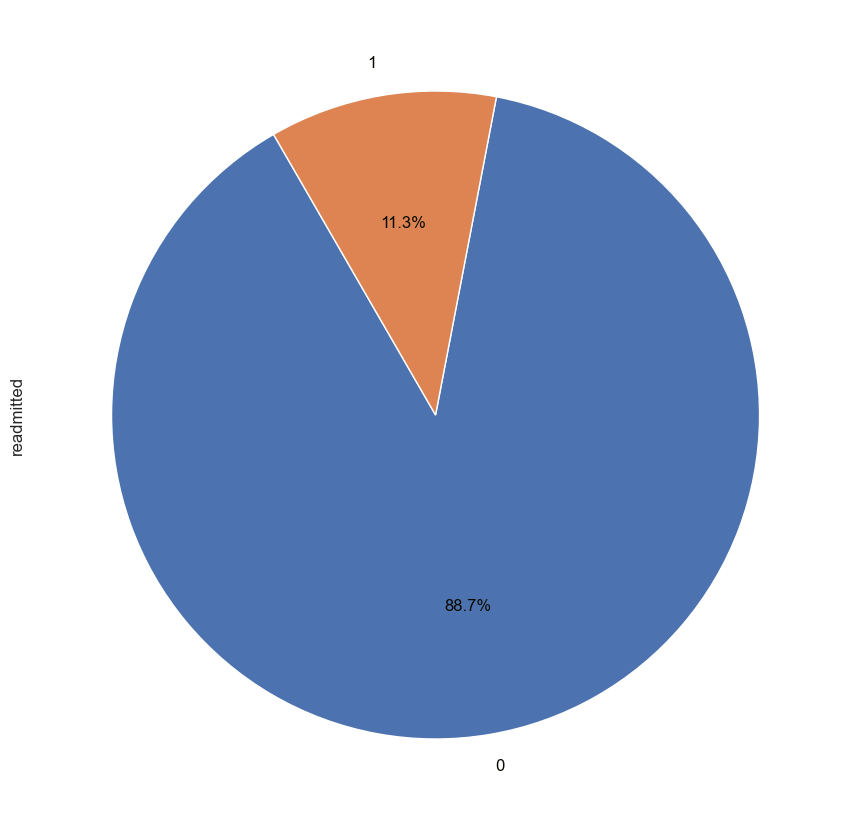

In [142]:
plt.figure()
sns.set_theme(style="whitegrid")
ax = sns.countplot(x = 'readmitted', data = data, hue = 'readmitted')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels = ['Not Admitted', 'Admitted'])
plt.figure()
data.readmitted.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'})

If the frequency of person's visit to the hospital is high then we can think of that person to be less healthier and less healthier patient tends to readmit quickly lets create health_index variable.Higher the health_index lesser the chance that person will readmit (indirectely propotional)

Health_index = ( 1 / (number_emergency + number_inpatient + number_outpatient) )

Severity of disease is high if patient is spending lots of time in hospital and going through number of complicated test so, lets create severity of disease as feature. To get probablistic interpretation lets divide it by total values.

severity_of_disease = (time_in_hospital + num_procedures + num_medications + num_lab_procedures + number_of_diagnoses)


Research has found that the patient which keep going through changes(up/down) in proportion of medications is tend to readmit so we have engineered new variable called as 'number_of_changes'. This captures number of medications whose proportion have changed for each patient.

In [143]:
data['health_index'] = data.apply(lambda x:  1 / (x['number_emergency'] + x['number_inpatient'] + x['number_outpatient'])
                                  if x['number_emergency'] != 0 or x['number_inpatient'] != 0 or x['number_outpatient'] != 0
                                  else 1, axis = 1)



total = data['time_in_hospital'].sum() + data['num_procedures'].sum() + data['num_medications'].sum()+\
                                data['num_lab_procedures'].sum() + data['number_diagnoses'].sum()

data['severity_of_disease'] = (data['time_in_hospital'] + data['num_procedures'] + 
                              data['num_medications'] + data['num_lab_procedures'] + 
                              data['number_diagnoses']) / total

drugList = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',
            'troglitazone','tolazamide','examide','citoglipton','insulin','glyburide.metformin','glipizide.metformin',
            'glimepiride.pioglitazone','metformin.rosiglitazone','metformin.pioglitazone']


number_of_changes = []
for i in range(len(data)):
    changeCount = 0
    for col in drugList : 
        if data.iloc[i][col] in ['Down', 'Up'] :
            changeCount += 1
    number_of_changes.append(changeCount)

data['number_of_changes'] = number_of_changes

Glucose Serum test :
A blood glucose test is used to find out if your blood sugar levels are in the healthy range. It is often used to help diagnose and monitor diabetes.

'>200' : 200 = indicates diabetes

'>300' : 300 = Indicates diabetes

'Norm' : 100 = Normal

'None' : 0 = test was not taken

In [144]:
data['max_glu_serum'] = data['max_glu_serum'].apply(lambda x : 200 if x == '>200' else ( 300 if x == '>300' else ( 100 if x == 'Norm' else  0)))

A1C test :
An A1C test is a blood test that reflects your average blood glucose levels over the past 3 months

'>7' : 7

'>8' : 8

Norm : 5 = Normal

None : 0 = Test was not taken

In [145]:
data['A1Cresult'] = data['A1Cresult'].apply(lambda x : 7 if x == '>7' else (8 if  x == '>8' else ( 5 if x == 'Norm' else  0)))

In [146]:
for col in drugList:
    data[col] = data[col].apply(lambda x : 10 if x == 'Up' else ( -10 if x == 'Down' else ( 0 if x == 'Steady' else  -20)))


data['change'] = data['change'].apply(lambda x : 1 if x == 'Ch' else -1)

In [147]:
## Engineered Features from domain knowledge
data['total_procedures'] = data['num_procedures'] + data['num_lab_procedures']
data['total_medical_interactions'] = data['number_outpatient'] + data['number_emergency'] + data['number_inpatient']
data['medication_ratio'] = data['num_medications'] / data['time_in_hospital']
data['avg_procedures_per_visit'] = data['total_procedures'] / (data['number_outpatient'] + data['number_inpatient'])
data['diagnoses_per_procedure'] = data['number_diagnoses'] / data['total_procedures']

data["time_in_hospital_per_procedure"] = data["time_in_hospital"] / data["num_procedures"]
data["number_medications_per_diagnosis"] = data["num_medications"] / data["number_diagnoses"]
data["average_lab_procedure_cost"] = data["num_lab_procedures"].mean()
data["emergency_room_visit_rate"] = data["number_emergency"] / data.shape[0]
data["inpatient_admission_rate"] = data["number_inpatient"] / data.shape[0]

In [148]:
data_checkpoint = data.copy()     ### storing the data to avoid redoing things again and again

In [149]:
data_checkpoint

race  gender  age  admission_type_id  \
0             Caucasian  Female    5                  5   
1             Caucasian  Female   15                  1   
2       AfricanAmerican  Female   25                  1   
3             Caucasian    Male   35                  1   
4             Caucasian    Male   45                  1   
...                 ...     ...  ...                ...   
101761  AfricanAmerican    Male   75                  1   
101762  AfricanAmerican  Female   85                  1   
101763        Caucasian    Male   75                  1   
101764        Caucasian  Female   85                  1   
101765        Caucasian    Male   75                  1   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
0                             18                    1                 1   
1                              1                    7                 3   
2                              1                    7                 2   
3                              1                    7                 2   
4                              1                    7                 1   
...                          ...                  ...               ...   
101761                         2                    7                 3   
101762                         2                    4                 5   
101763                         1                    7                 1   
101764                         2                    7                10   
101765                         1                    7                 6   

       medical_specialty  num_lab_procedures  num_procedures  num_medications  \
0             pediatrics                  41               0                1   
1                missing                  59               0               18   
2                missing                  11               5               13   
3                missing                  44               1               16   
4                missing                  51               0                8   
...                  ...                 ...             ...              ...   
101761           missing                  51               0               16   
101762           missing                  33               3               18   
101763           missing                  53               0                9   
101764           surgery                  45               2               21   
101765           missing                  13               3                3   

        number_outpatient  number_emergency  number_inpatient     diag_1  \
0                       0                 0                 0   diabetes   
1                       0                 0                 0      other   
2                       2                 0                 1   pregnecy   
3                       0                 0                 0      other   
4                       0                 0                 0  neoplasms   
...                   ...               ...               ...        ...   
101761                  0                 0                 0   diabetes   
101762                  0                 0                 1  digestive   
101763                  1                 0                 0      other   
101764                  0                 0                 1     injury   
101765                  0                 0                 0  digestive   

           diag_2       diag_3  number_diagnoses  max_glu_serum  A1Cresult  \
0        diabetes     diabetes                 1              0          0   
1           other        other                 9              0          0   
2        pregnecy        other                 6              0          0   
3           other  circulatory                 7              0          0   
4       neoplasms     diabetes                 5              0          0   
...           ...          ...               ...       

In [150]:
numerical_feature = [i for i in data.columns if data[i].dtypes == np.int64 or data[i].dtypes == float]
categorical_feature = [i for i in data.columns if data[i].dtypes != np.int64 or data[i].dtypes != float]

In [151]:
data[numerical_feature].corr()

age  admission_type_id  \
age                               1.000000          -0.005037   
admission_type_id                -0.005037           1.000000   
discharge_disposition_id          0.010197           0.078516   
admission_source_id               0.039141          -0.188376   
time_in_hospital                  0.108258          -0.023393   
num_lab_procedures                0.017872          -0.158222   
num_procedures                   -0.029564           0.117560   
num_medications                   0.042493           0.100617   
number_outpatient                 0.023853           0.039430   
number_emergency                 -0.087552          -0.021599   
number_inpatient                 -0.043610          -0.039480   
number_diagnoses                  0.242649          -0.104142   
max_glu_serum                     0.019355           0.374252   
A1Cresult                        -0.131876          -0.061220   
metformin                        -0.055550           0.018859   
repaglinide                       0.050427          -0.016994   
nateglinide                       0.017769          -0.009945   
chlorpropamide                    0.013812           0.008291   
glimepiride                       0.039058          -0.012056   
acetohexamide                     0.001817          -0.001861   
glipizide                         0.055945           0.008522   
glyburide                         0.077644           0.003465   
tolbutamide                       0.010491           0.003909   
pioglitazone                      0.014622           0.013731   
rosiglitazone                     0.005199           0.016271   
acarbose                          0.007823           0.004763   
miglitol                          0.011106          -0.003762   
troglitazone                     -0.001429           0.002261   
tolazamide                        0.005379           0.007878   
examide                                NaN                NaN   
citoglipton                            NaN                NaN   
insulin                          -0.076593          -0.021473   
glyburide.metformin              -0.001206          -0.002137   
glipizide.metformin               0.002155          -0.002758   
glimepiride.pioglitazone         -0.000165          -0.001861   
metformin.rosiglitazone           0.002570           0.000726   
metformin.pioglitazone           -0.000165           0.002888   
change                           -0.034316           0.009649   
diabetesMed                      -0.019746          -0.002387   
readmitted                        0.020842          -0.012852   
health_index                      0.013586           0.000763   
severity_of_disease               0.056422          -0.092757   
number_of_changes                -0.064529           0.016023   
total_procedures                  0.015186          -0.146831   
total_medical_interactions       -0.046575          -0.008804   
medication_ratio                 -0.065503           0.128349   
avg_procedures_per_visit          0.038691          -0.100708   
diagnoses_per_procedure           0.018014           0.001132   
time_in_hospital_per_procedure    0.095304          -0.100288   
number_medications_per_diagnosis -0.098419           0.158916   
average_lab_procedure_cost             NaN                NaN   
emergency_room_visit_rate        -0.087552          -0.021599   
inpatient_admission_rate         -0.043610          -0.039480   

                                  discharge_disposition_id  \
age                                               0.010197   
admission_type_id                                 0.078516   
discharge_disposition_id                          1.000000   
admission_source_id                              -0.001348   
time_in_hospital                                  0.063721   
num_lab_procedures                                0.000157   
num_procedures                                    0.007864   
num_medications                 

Analysis to use spearsman correlation coefficient to check whether numerical features and readmitted column are dependant or independant if some features are found to be independant on readmitted we will simply remove them

As we can see that correlation is always close to zero but, spearman doesnt capture the non-linear relationships so, rather than using correlation coeff we will use pvalue to get "rejected features list" Here hypothesis testing is done assuming null hypothesis to be "variables are independant" so assuming significance level = alpha = 0.35 if pvalue < alpha then reject null hypothesis that is we accept variables are dependant

In [152]:
import scipy 

In [153]:
rejected_features = []
accepted_features = []

for col in numerical_feature :
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    print(col, rho, pval)
    print("")
    

for col in numerical_feature :
    rho , pval = scipy.stats.spearmanr(data['readmitted'], data[col])
    if pval < 0.4 : 
        accepted_features.append(col)
    else : 
        rejected_features.append(col)

print("List of Features Rejected")
print(rejected_features)

data.drop(rejected_features, axis = 1, inplace=True)

age 0.022833605581275368 4.98944098058298e-13

admission_type_id -0.014481278339963873 4.601649022559362e-06

discharge_disposition_id 0.07363362299946696 2.21810763501907e-120

admission_source_id 0.013506833052898206 1.9215983012628208e-05

time_in_hospital 0.05171465000683055 2.9484026979053584e-60

num_lab_procedures 0.023467887405344154 1.116299310707751e-13

num_procedures -0.004338904445235903 0.16979797453968323

num_medications 0.04746213492122893 4.984906428976816e-51

number_outpatient 0.034247287359244524 2.2452669366328554e-27

number_emergency 0.06412935666236855 1.0134729189365564e-91

number_inpatient 0.14089150016426985 0.0

number_diagnoses 0.05014531714323302 9.267063809654418e-57

max_glu_serum 0.009959005439830653 0.001626303759336354

A1Cresult -0.01988435018629698 3.131789332831799e-10

metformin -0.025506239319911257 6.938881254102491e-16

repaglinide 0.008197839011717101 0.009490160440533623

nateglinide 0.000435666360837421 0.8903616608651332

chlorpropamide -

In [154]:
import statsmodels.api as sm

def statistical_analysis(df):
    """
    Compute the summary statistics for each numerical column which include
    Mean, Standard Deviation, Skew, Kurtosis, as well as the 
    first order Autocorrelation estimate and its t-stat
    """
    summary = pd.DataFrame({
        "Mean" : df.mean(),
        "Std Dev": df.std(),
        "Skew" : df.apply(skew),
        "Kurtosis": df.apply(kurtosis)
    })
    
    acf_tstat = pd.DataFrame(columns = ['T-Stat'])
    
    for col in df.columns:
        acf = sm.tsa.stattools.acf(data[col], nlags = 1)[1]
        acf_tstat.loc[col] = [acf/ np.sqrt(len(df))]
    
    results = pd.concat([summary, acf_tstat], axis = 1)
    return results



In [155]:
result = statistical_analysis(df = data[[i for i in data.columns if data[i].dtypes != "object"]])
result

Mean    Std Dev       Skew  \
age                               65.830953  15.947425  -0.626691   
admission_type_id                  1.783667   1.330994   1.441207   
discharge_disposition_id           2.088359   3.725944   4.127874   
admission_source_id                5.119314   2.880833  -0.570573   
time_in_hospital                   4.389646   2.974531   1.137864   
num_lab_procedures                42.943305  19.620940  -0.241456   
num_procedures                     1.330723   1.700286   1.326109   
num_medications                   15.981821   8.092511   1.333098   
number_outpatient                  0.369429   1.264006   8.817999   
number_emergency                   0.198334   0.935537  22.841802   
number_inpatient                   0.632829   1.261833   3.626420   
number_diagnoses                   7.409164   1.938288  -0.867576   
max_glu_serum                      9.075654  42.879610   5.283608   
A1Cresult                          1.162685   2.635304   1.913712   
metformin                        -15.975788   8.180076   1.606534   
repaglinide                      -19.688555   2.532517   8.221573   
chlorpropamide                   -19.982520   0.605211  35.375575   
glimepiride                      -18.958687   4.529928   4.239244   
glyburide                        -17.864534   6.324902   2.735429   
tolbutamide                      -19.995805   0.289634  69.024152   
pioglitazone                     -18.534171   5.266930   3.368455   
rosiglitazone                    -18.726951   4.926771   3.660947   
acarbose                         -19.937971   1.124153  18.291449   
insulin                           -9.417364  10.995387   0.384750   
change                            -0.072198   0.997395   0.144773   
diabetesMed                        0.771840   0.419648  -1.295568   
readmitted                         0.113441   0.317132   2.437855   
health_index                       0.832090   0.296320  -1.330674   
severity_of_disease                0.000010   0.000004   0.184378   
number_of_changes                  0.287542   0.487859   1.425330   
total_procedures                  44.274028  19.781814  -0.217825   
total_medical_interactions         1.200591   2.292775   5.334641   
medication_ratio                   5.061163   3.806133   2.210864   
avg_procedures_per_visit                inf        NaN        NaN   
diagnoses_per_procedure            0.379956   0.972591   6.516748   
time_in_hospital_per_procedure          inf        NaN        NaN   
number_medications_per_diagnosis   2.282230   1.322322   2.459574   
emergency_room_visit_rate          0.000002   0.000009  22.841802   
inpatient_admission_rate           0.000006   0.000013   3.626420   

                                     Kurtosis        T-Stat  
age                                  0.274194  2.932362e-05  
admission_type_id                    0.703495  2.781926e-04  
discharge_disposition_id            15.939251  9.792589e-04  
admission_source_id                 -1.390028  4.177205e-04  
time_in_hospital                     0.870927  6.358810e-05  
num_lab_procedures                  -0.253291  2.155715e-04  
num_procedures                       0.891054  8.314389e-05  
num_medications                      3.523620  1.224501e-04  
number_outpatient                  148.544463  6.898910e-05  
number_emergency                  1185.155821  2.841709e-05  
number_inpatient                    20.833069  3.114327e-05  
number_diagnoses                    -0.109544  3.350850e-04  
max_glu_serum                       28.806573  1.484103e-04  
A1Cresult                            1.852590  6.911284e-05  
metformin                            0.785317  5.147915e-08  
repaglinide                         67.758646 -6.452732e-06  
chlorpropamide                    1284.681756 -2.636540e-06  
glimepiride                         16.626671  3.144879e-05  
glyburide                            5.906418  2.868863e-05  
tolbutamide                       4762

## DATA VISUAIZATION

Univariate and Bivariate analysis of Different features

In [156]:
data2 = data.copy() 

<Axes: xlabel='discharge_disposition_id', ylabel='count'>

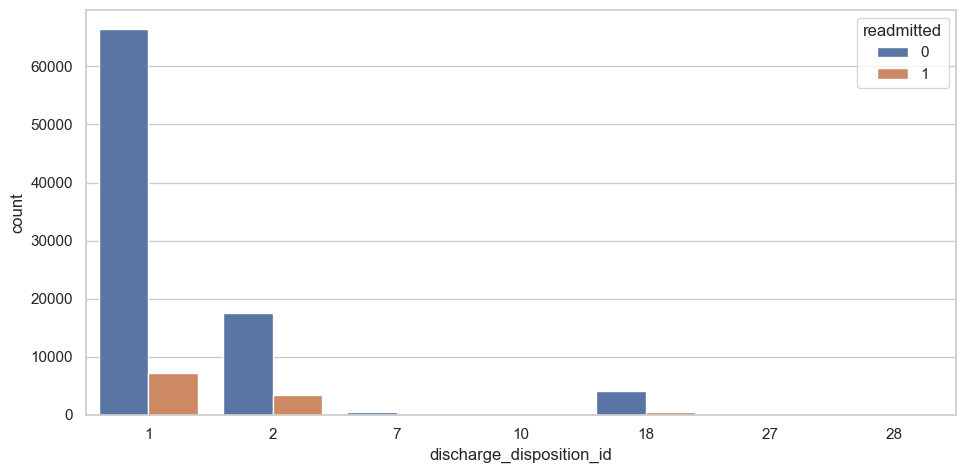

In [157]:
fig = plt.figure(figsize = (10, 5))

sns.countplot(x  = 'discharge_disposition_id', data = data2, hue = 'readmitted')

- From the graph it clear that if discharge disposition id is 7 the patient wont readmit.

<Axes: xlabel='number_inpatient', ylabel='count'>

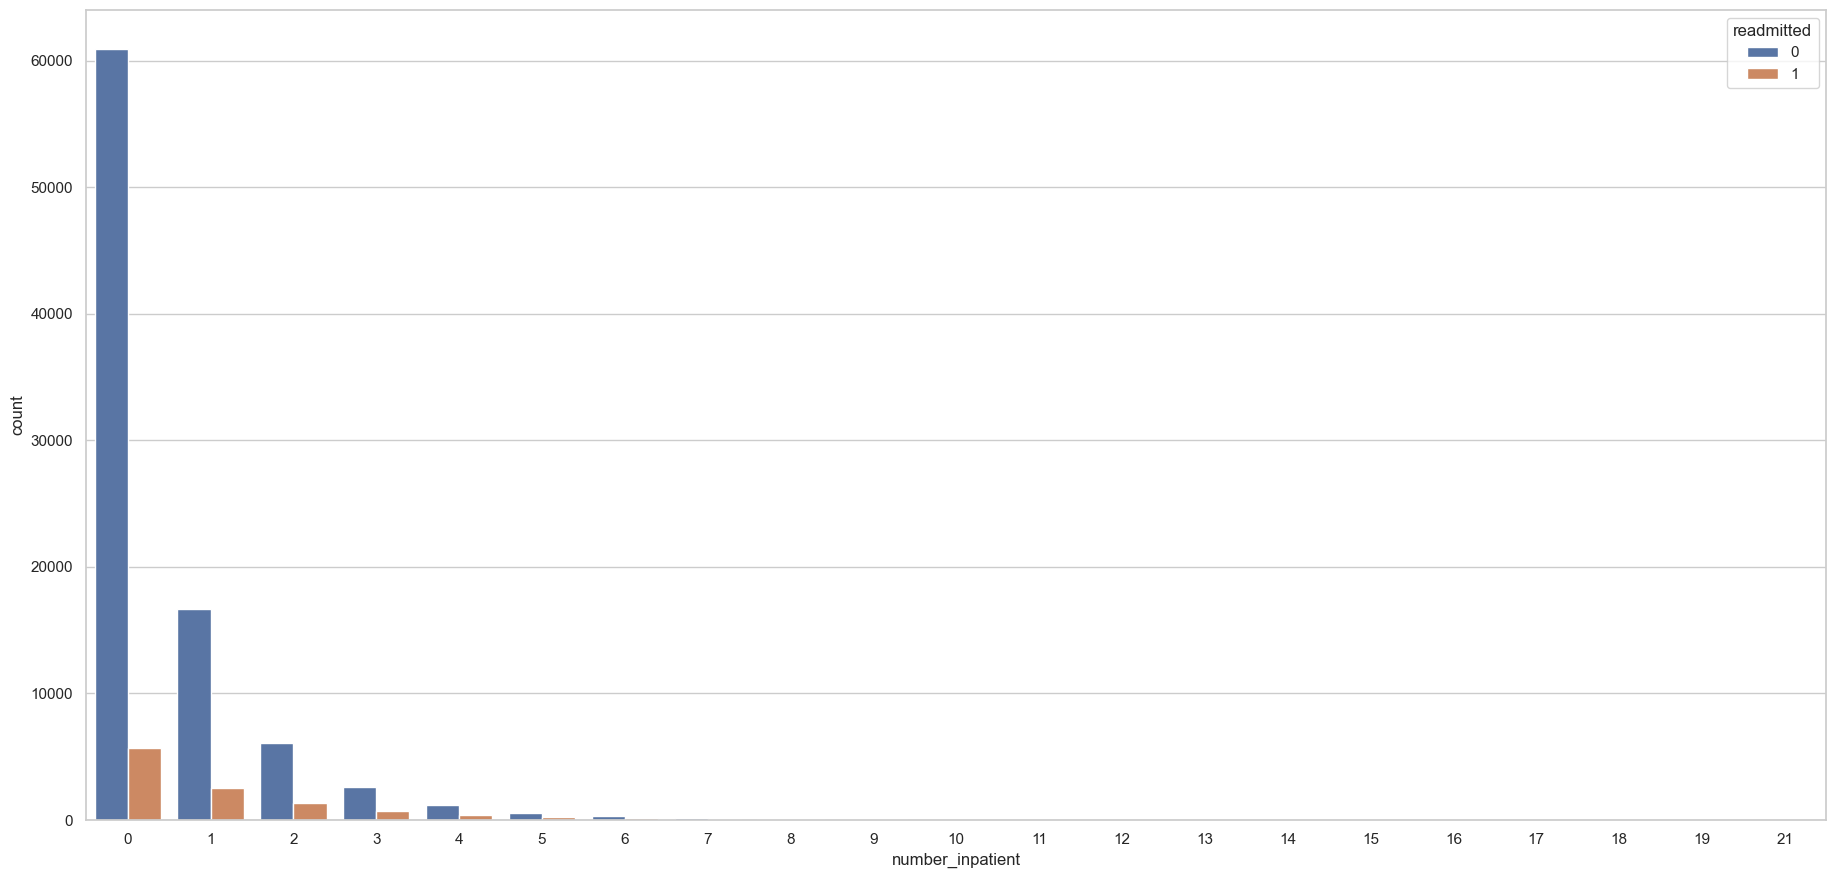

In [158]:
sns.countplot(x  = 'number_inpatient', data = data2, hue = 'readmitted')

- Number Inpatient: Most patient never admitted into the hospital and if patient has not admitted previously or admitted very few number of time there is very less chance that he will readmit.

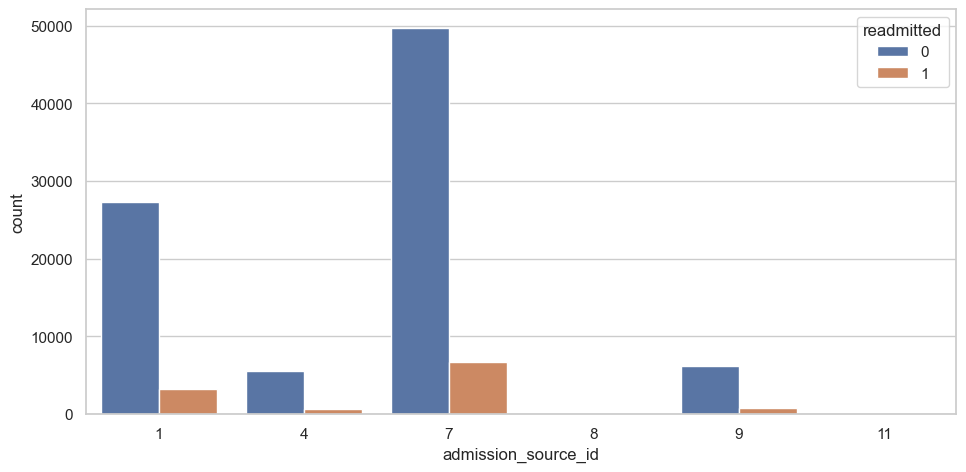

In [159]:
fig = plt.figure(figsize = (10, 5)) 
a = sns.countplot(x = 'admission_source_id', hue = 'readmitted', data = data2)

- Most of the patient who readmitted have admission source as 1 and so if some patient has source id as 1 he is more likely be going to readmit.

Text(0.5, 1.0, 'Not Readmitted Patient')

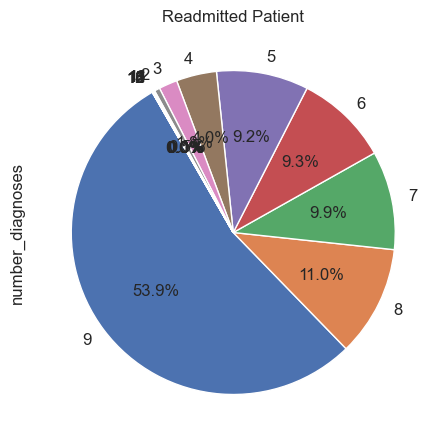

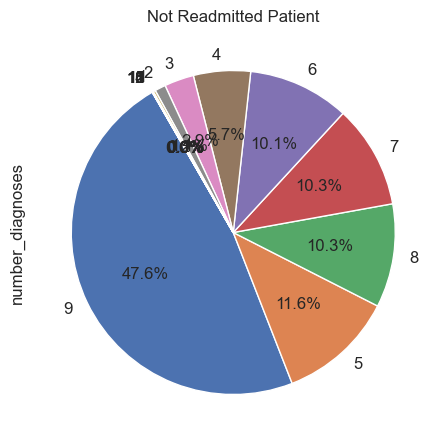

In [172]:
fig = plt.figure(figsize = (10, 5)) 


ax = data2[data2.readmitted == 1].number_diagnoses.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12 },)
ax.set_title('Readmitted Patient')
fig = plt.figure(figsize = (10, 5)) 


ax = data2[data2.readmitted == 0].number_diagnoses.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12},)
ax.set_title('Not Readmitted Patient')

- Distribution of number of diagnosis done by readmitted and not readmitted patient is almost the same hence we are not able to conclude anything from it.

Text(0.5, 1.0, 'Not Readmitted Patient')

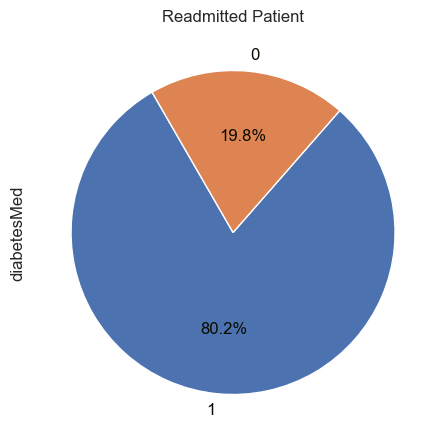

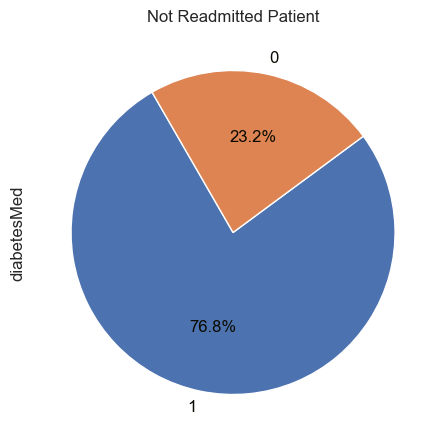

In [161]:
fig = plt.figure(figsize = (10, 5)) 

ax = data2[data2.readmitted == 1].diabetesMed.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Readmitted Patient')
fig = plt.figure(figsize = (10, 5)) 


ax = data2[data2.readmitted == 0].diabetesMed.value_counts().plot.pie(autopct="%1.1f%%", startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'},)
ax.set_title('Not Readmitted Patient')

- This feature tells whether the patient has taken Diabetes Medication or not. In our dataset Number of patient taken Diabetes Medication and "readmitted" is almost same as number of patients taken Diabetes medication and "not readmitted".But by iteracting with other feature Diabetes Med might reveal lot of information that is useful for given task.

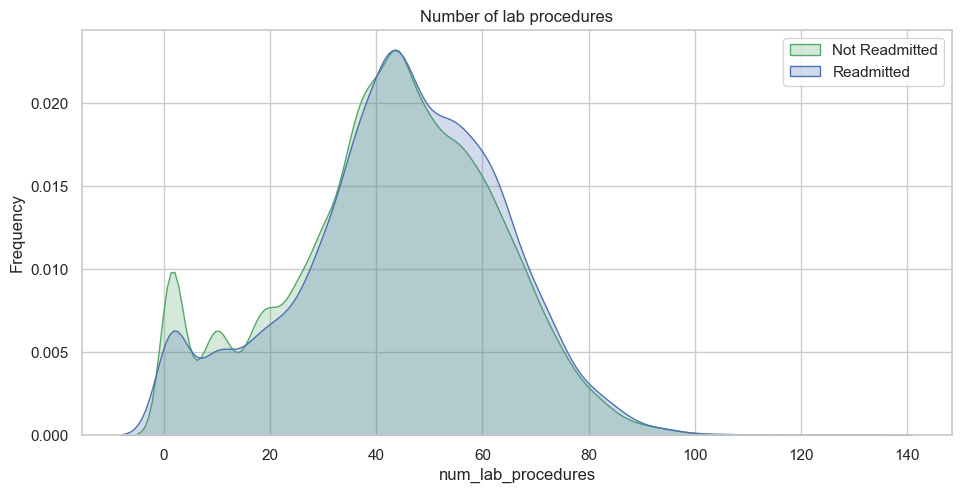

In [162]:
fig = plt.figure(figsize = (10, 5)) 
a = sns.kdeplot(data2.loc[(data2['readmitted'] == 0), "num_lab_procedures"] ,
                 color = "g", shade = True, label = "Not Readmitted")

a = sns.kdeplot(data2.loc[(data2['readmitted'] == 1), "num_lab_procedures"] ,
                 color = "b", shade = True, label = "Readmitted")

a.legend()
a.set_xlabel("num_lab_procedures")
a.set_ylabel("Frequency")
a.set_title("Number of lab procedures")
plt.show()

- Distribution Number of lab procedures for radmitted and not readmitted patient is exactely same. But it has high varience.High varience features are considered information rich features.

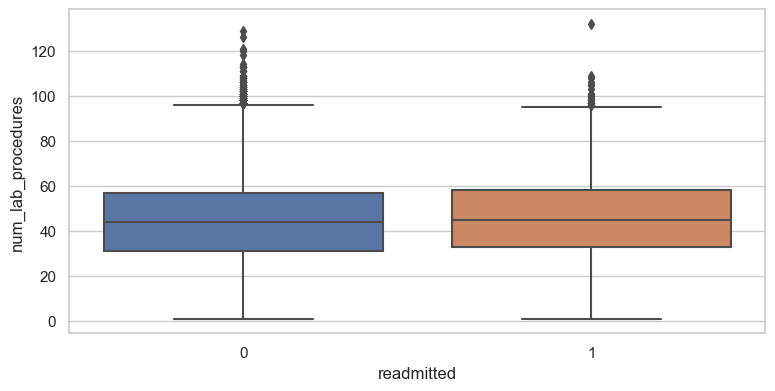

In [163]:
fig = plt.figure(figsize = (8, 4))
sns.boxplot(x = 'readmitted', y = 'num_lab_procedures', data = data2);

In [164]:
data2[data2.readmitted == 1].race.count

<bound method Series.count of 11        AfricanAmerican
12              Caucasian
16        AfricanAmerican
46              Caucasian
50        AfricanAmerican
               ...       
101699          Caucasian
101727          Caucasian
101732                NaN
101746          Caucasian
101750          Caucasian
Name: race, Length: 11357, dtype: object>

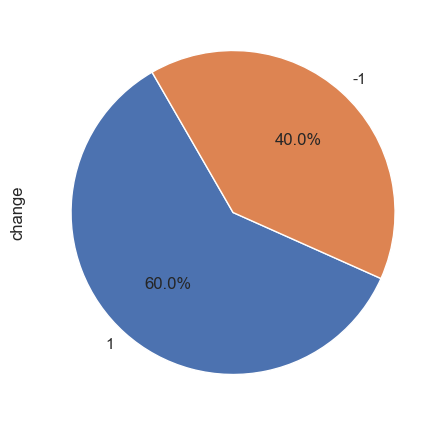

In [165]:
fig = plt.figure(figsize = (10, 5)) 
ax = data2[(data2.readmitted == 0) & (data2.diabetesMed == 1 )].change.value_counts().plot.pie(autopct="%1.1f%%", startangle=120)

Between Change and DiabetesMed :

From pie chart it clear that if the patient has no changes in medication and has not taken any diabetic medication he has more chance of getting redmitted than the patient who has taken diabetesMed and has no changes in medication.

<Axes: xlabel='age', ylabel='time_in_hospital'>

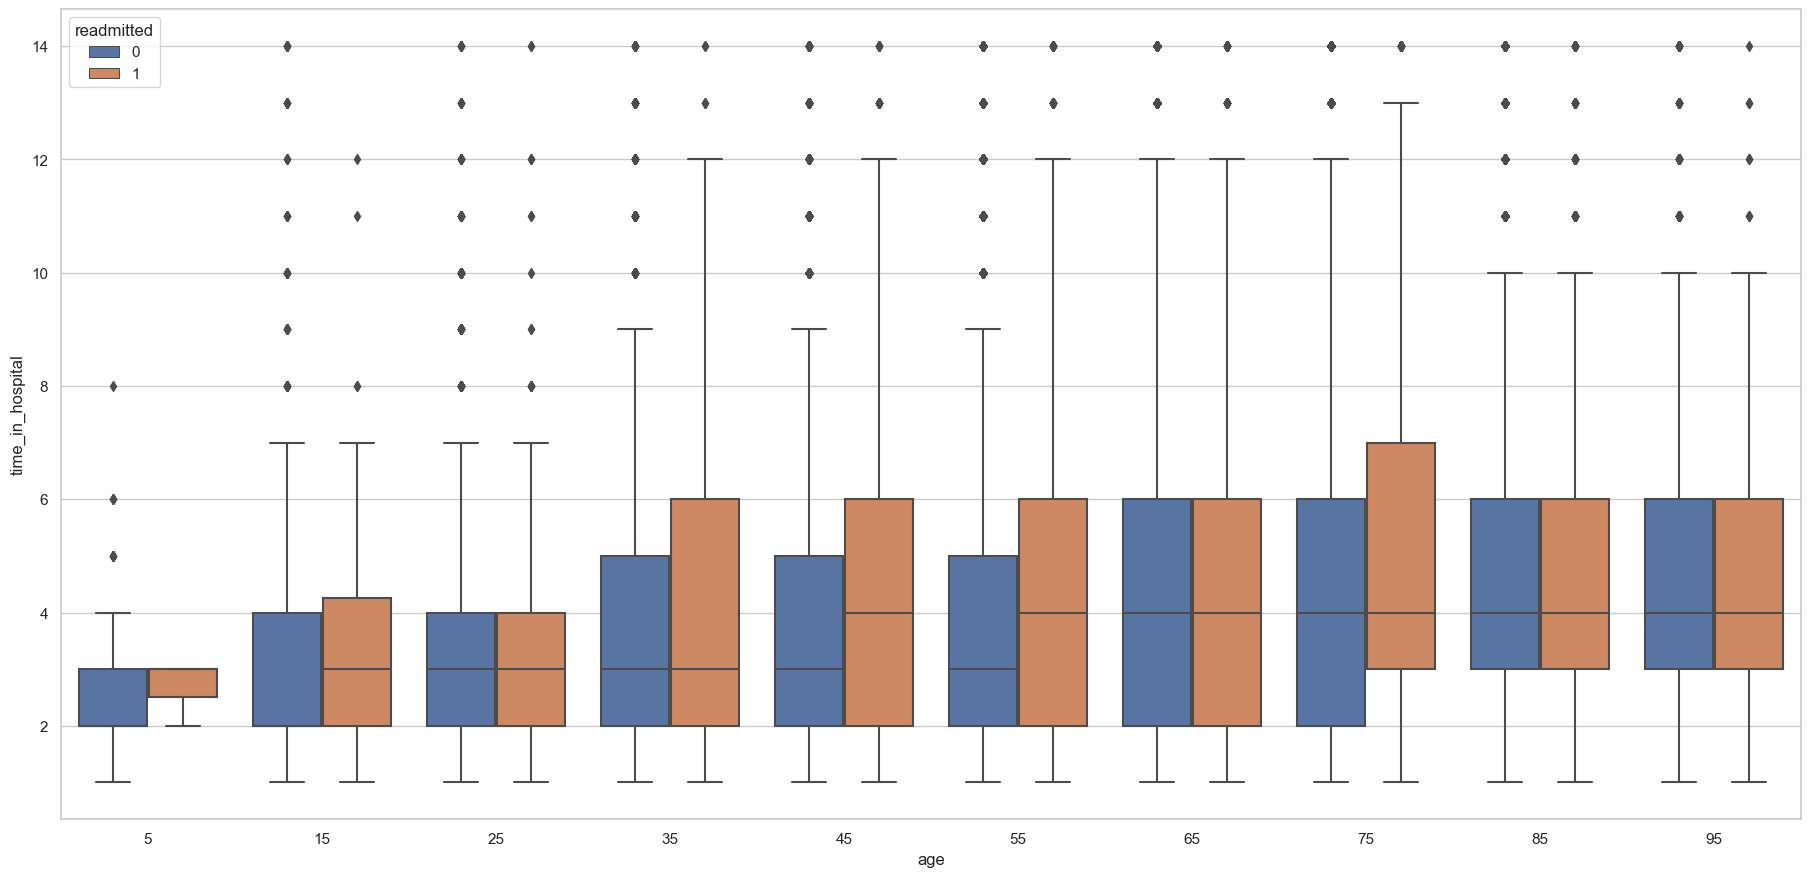

In [166]:
plt.figure(figsize = (20,10))
sns.boxplot(x='age', y = 'time_in_hospital', hue = 'readmitted', data = data2)

Younger people tend to admit in the hospital more often. The patient who have readmitted have high number of inpatient feature value can be seen for group age 25

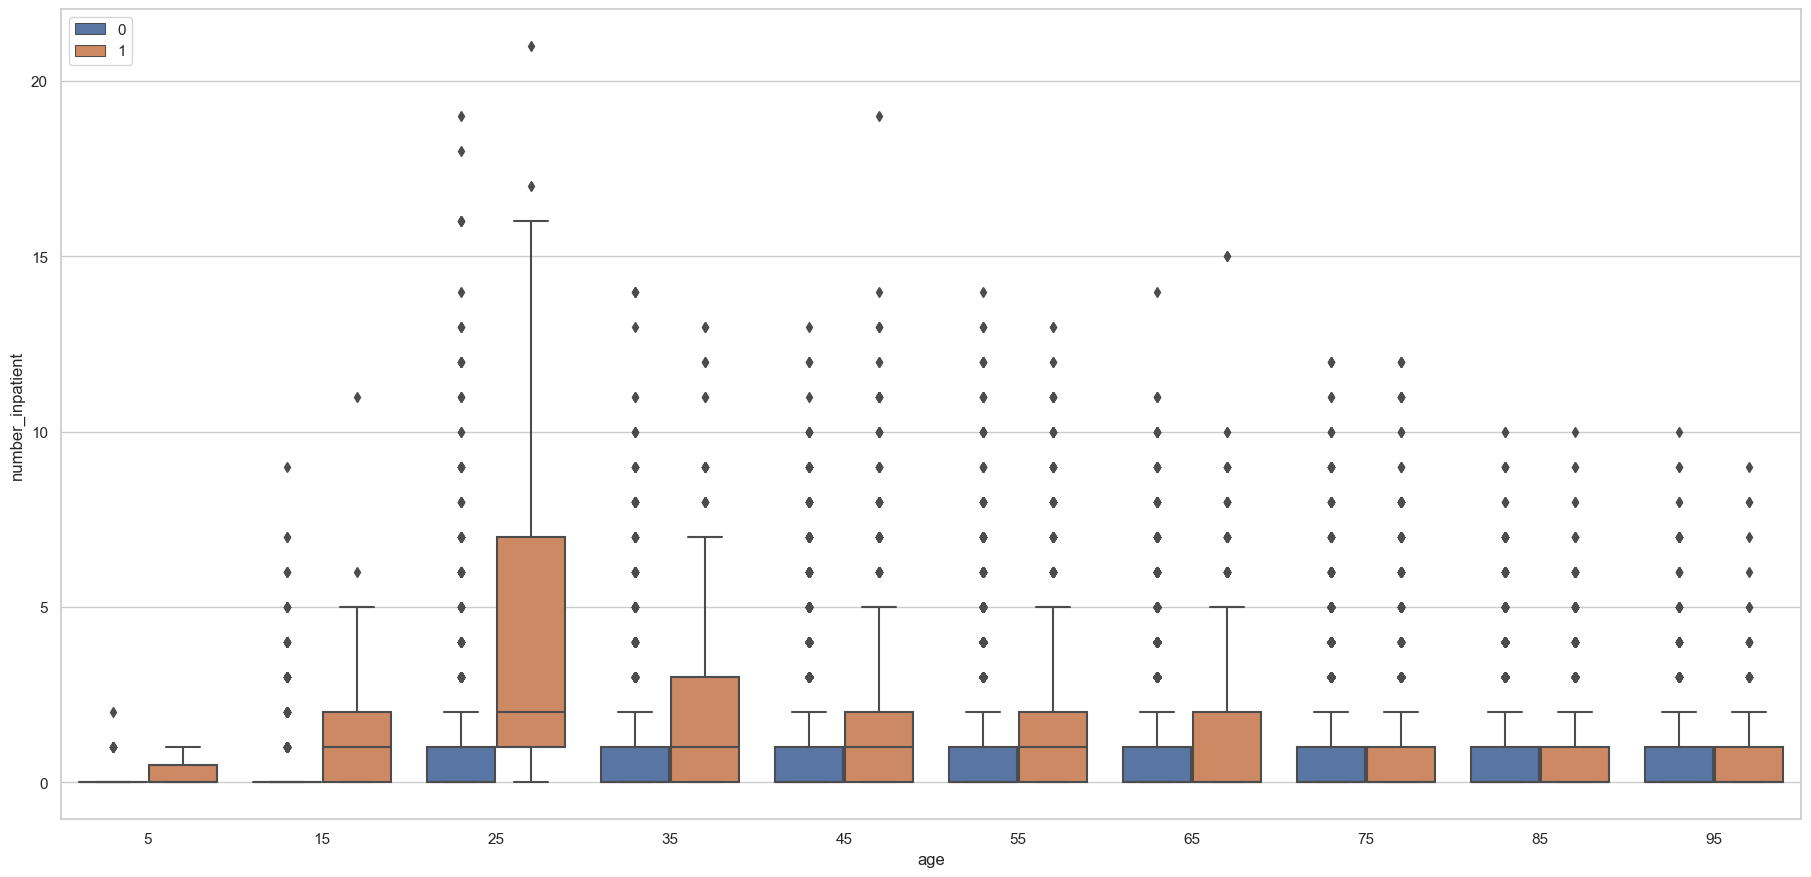

In [167]:
plt.figure(figsize = (20,10))
ax = sns.boxplot(x='age', y = 'number_inpatient', hue = 'readmitted', data = data2)
ax.legend(loc = 'upper left');

From pie chart we can infer that, If there is patient with source id = 5 and change feature has val as 0 then that patient has less chance of readmitting than the patient with admission id in 15  and has no change.

correlation analysis and statistical analysis

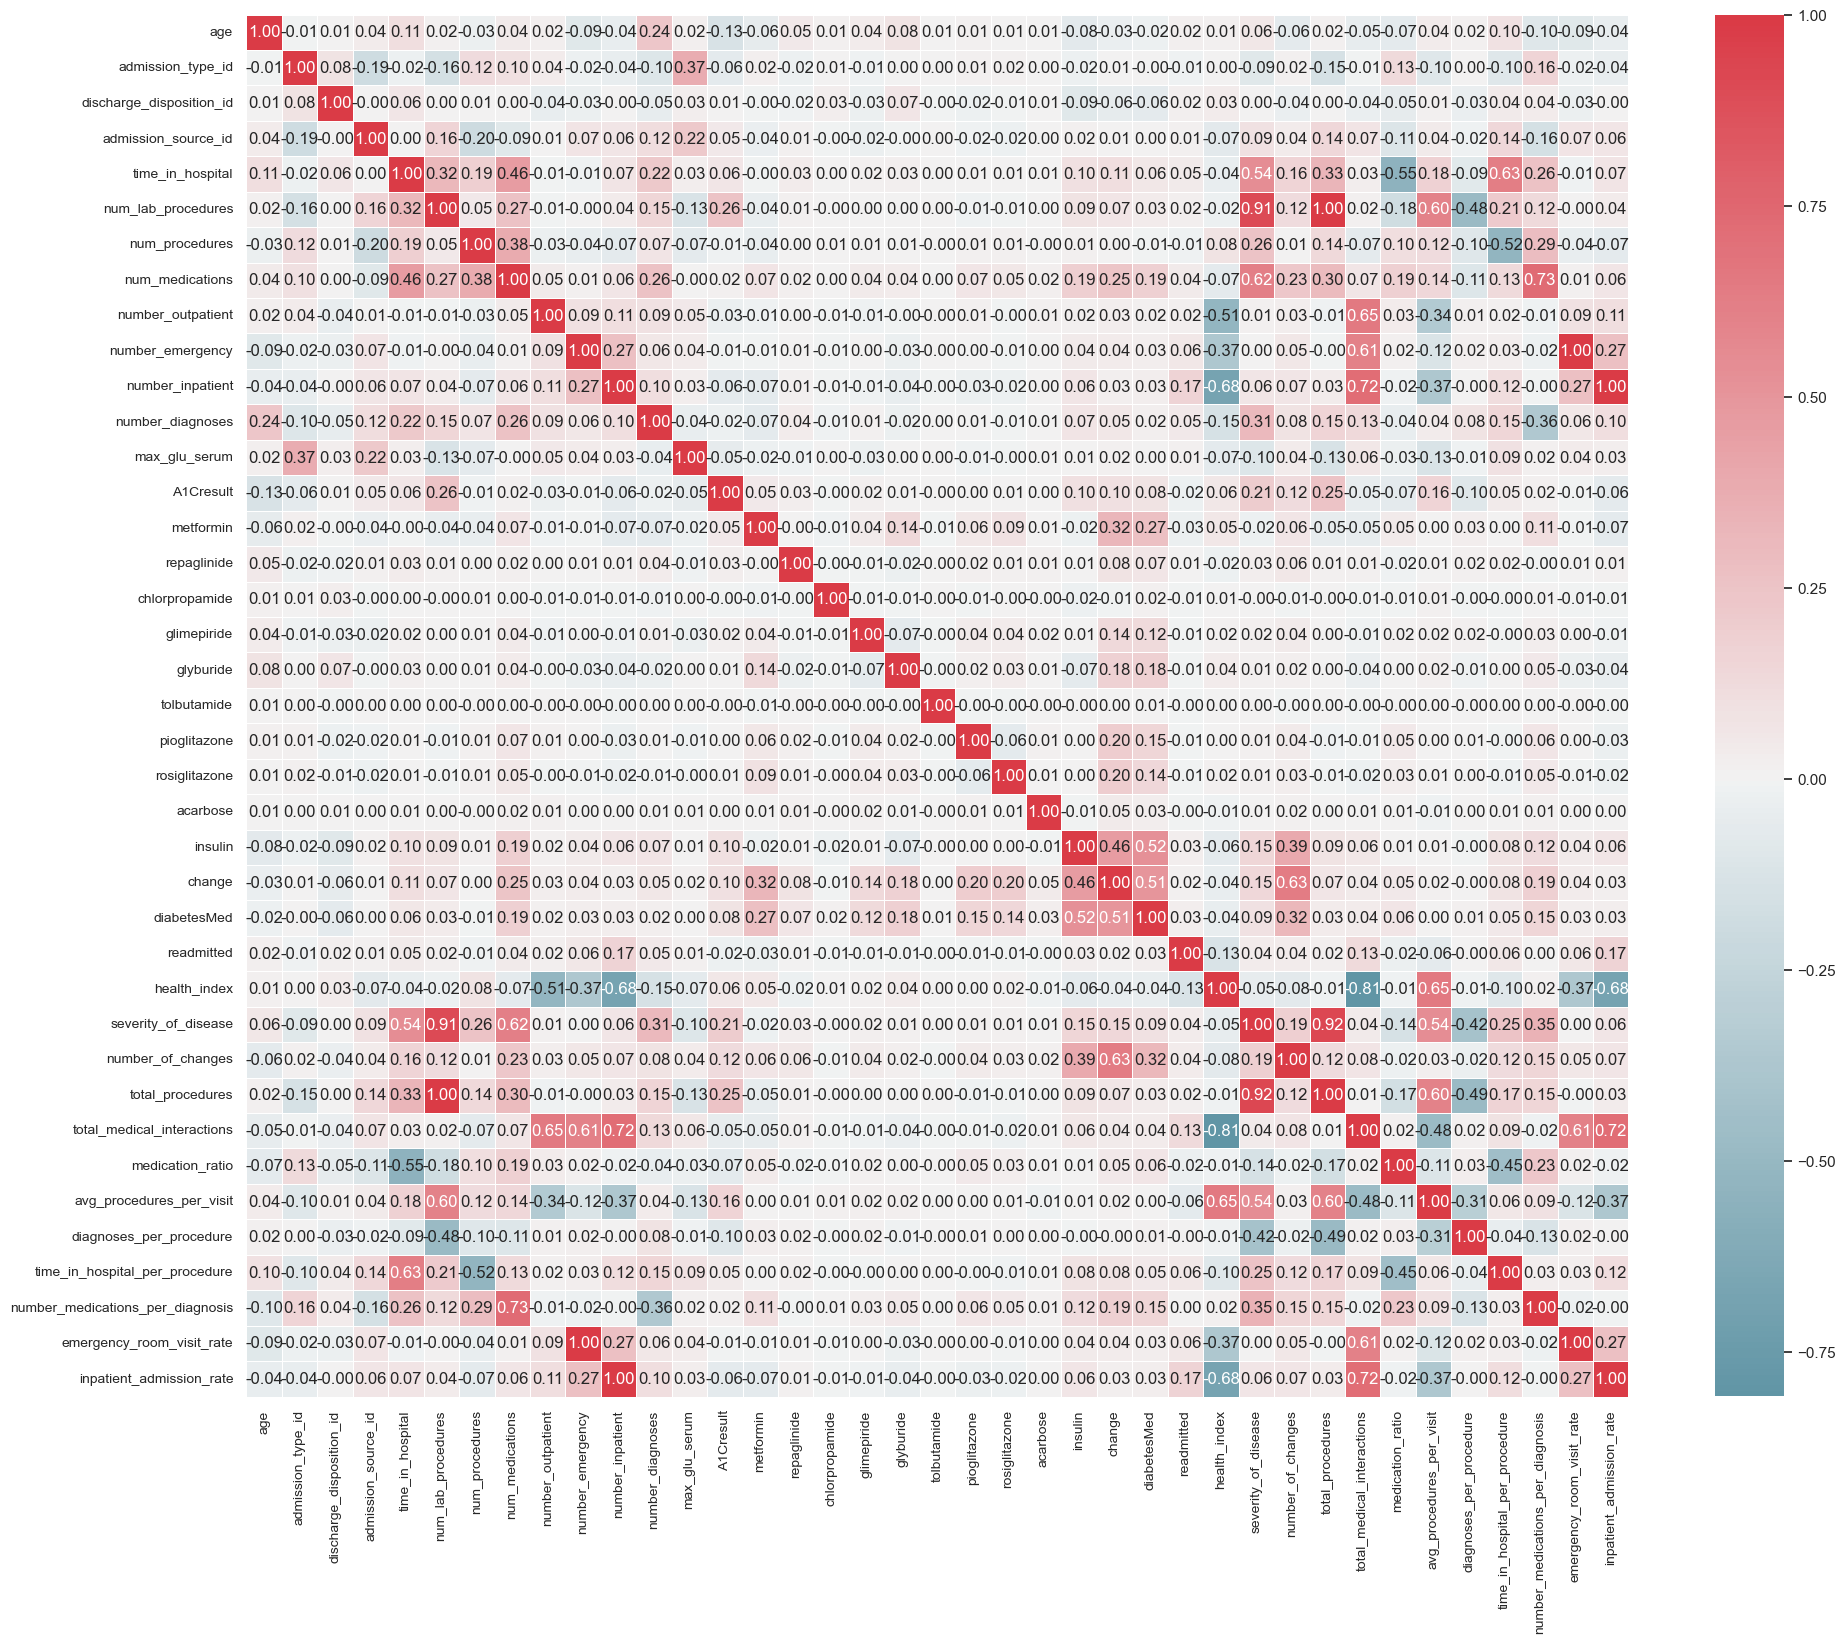

In [168]:
# Correlation
def HeatMap(df,x=True):
    correlations = df.corr()
    ## Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, ax = plt.subplots(figsize=(20, 20))
    fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',square=True, linewidths=.5, annot=x, cbar_kws={"shrink": .75})
    fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
    fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.tight_layout()
    plt.show()

HeatMap(data2,x=True)

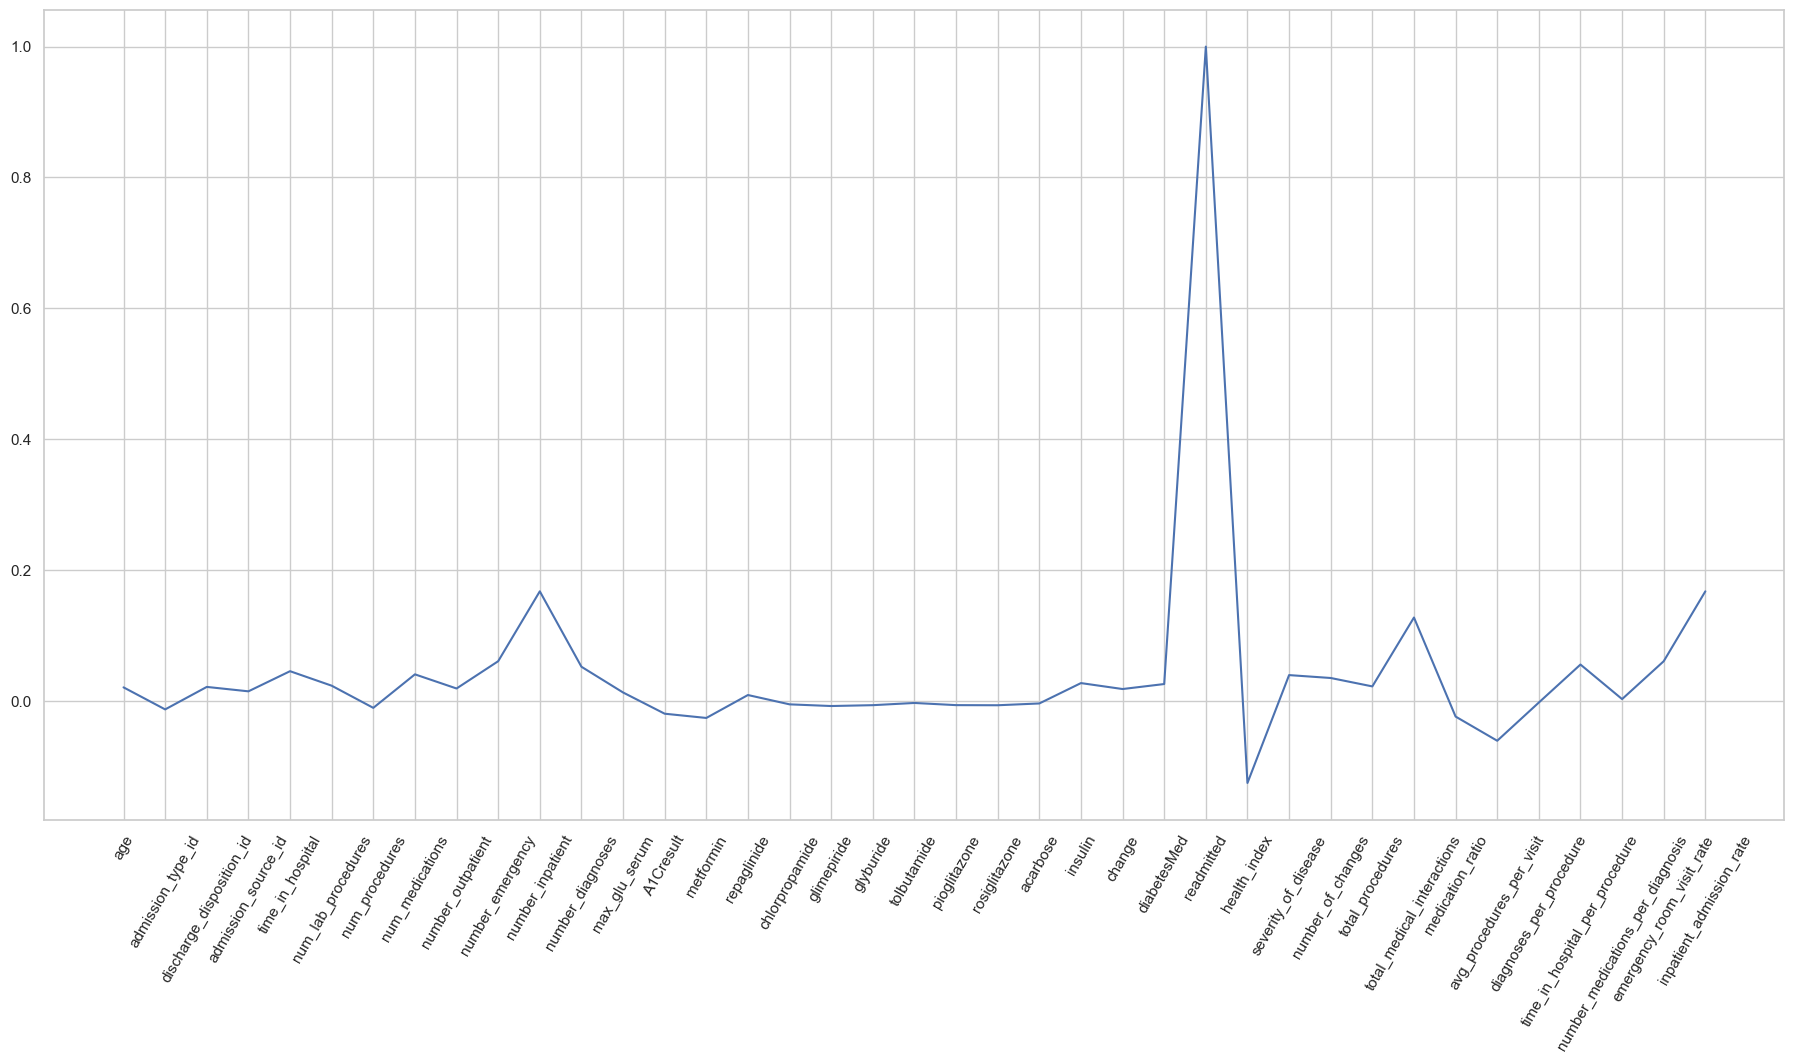

In [169]:
plt.figure(figsize = (20,10))
plt.xticks(rotation = 60)
plt.plot(data2.corr()['readmitted']);

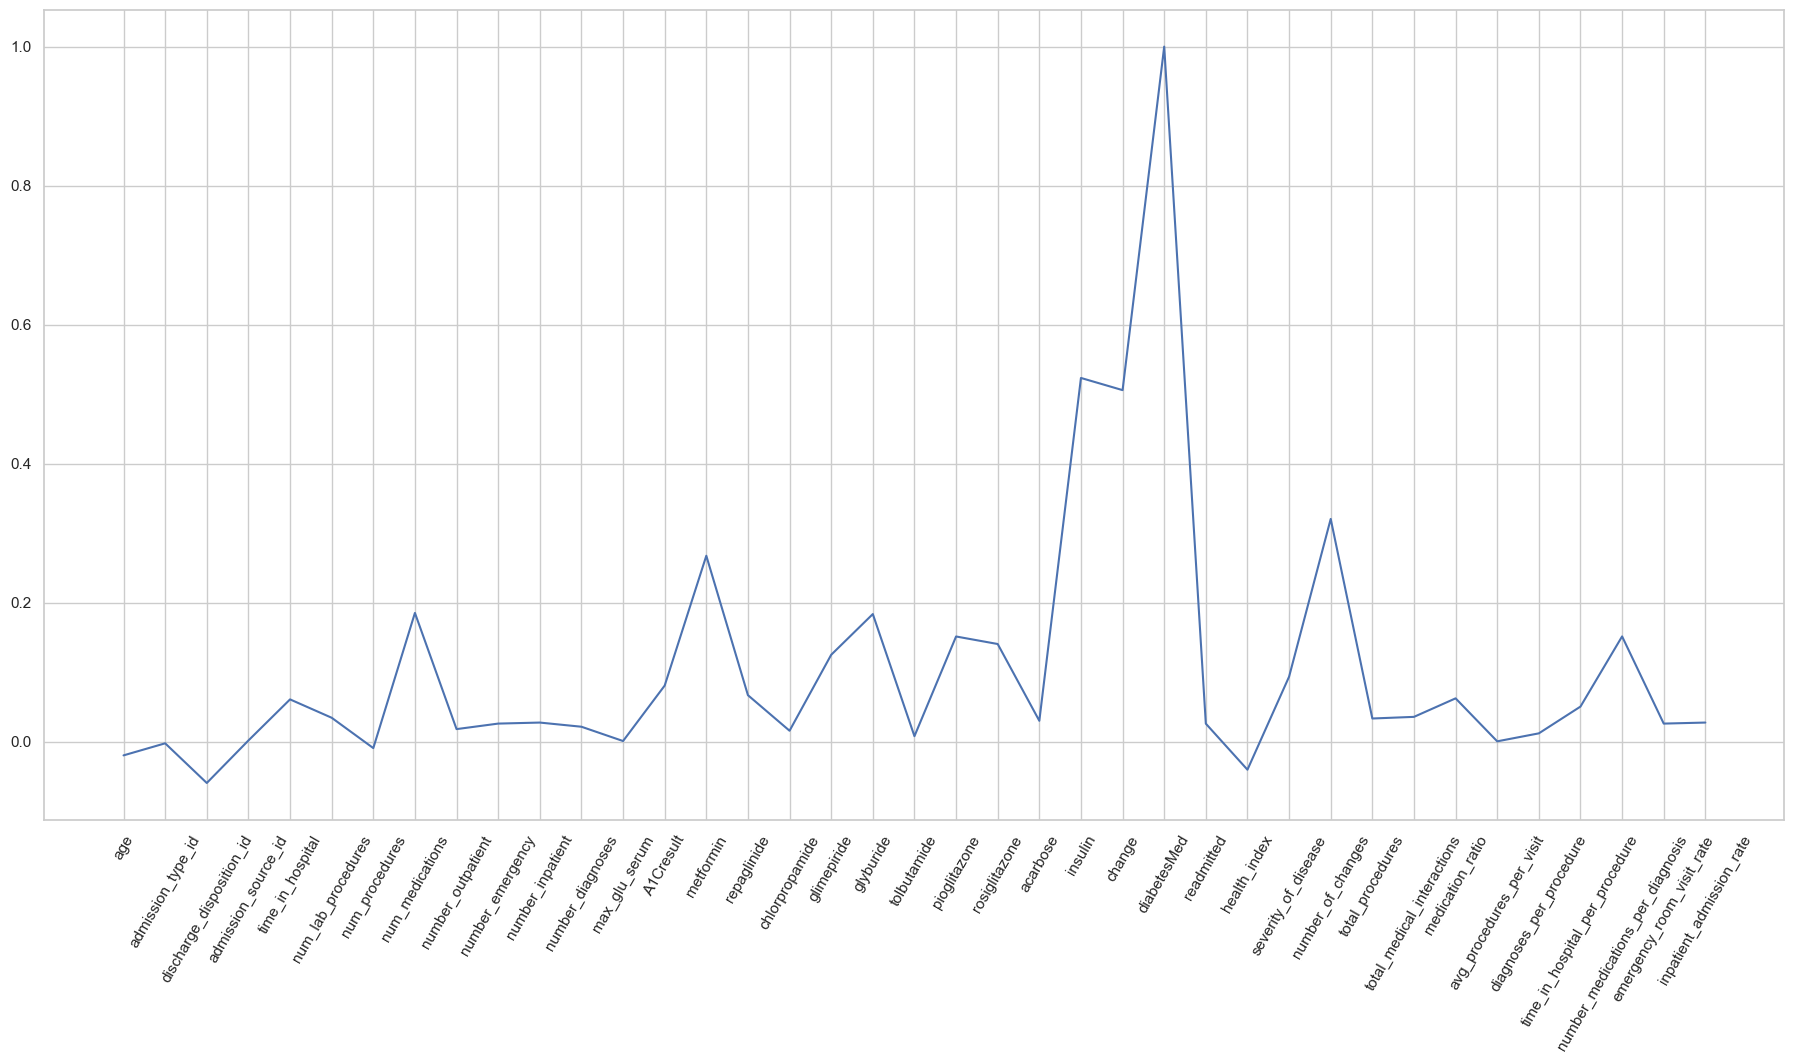

In [170]:
plt.figure(figsize = (20,10))
plt.xticks(rotation = 60)
plt.plot(data2.corr()['diabetesMed']);